In [1]:
import ray

ray.shutdown()
ray.init(ignore_reinit_error=True, num_gpus=1, _metrics_export_port=8080, include_dashboard=True,
         configure_logging=False)

Python version:,3.9.18
Ray version:,2.9.1
Dashboard:,http://127.0.0.1:8265


In [2]:
from minigrid.wrappers import FlatObsWrapper


class CustomFlatObsWrapper(FlatObsWrapper):
    def __init__(self, env):
        super().__init__(env)

pygame 2.5.2 (SDL 2.28.3, Python 3.9.18)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [11]:
try:
    import gymnasium as gym

    gymnasium = True
except Exception:
    import gym

    gymnasium = False
from ray.tune import register_env


def env_creator(env_config):
    env = gym.make("MiniGrid-MultiRoom-N6-v0", **env_config)
    env.reset()
    env = CustomFlatObsWrapper(env)
    return env


# Register the custom environment
register_env("my_minigrid_env", env_creator)

In [13]:
from ray.rllib.algorithms.callbacks import DefaultCallbacks
from ray.rllib import BaseEnv, Policy
from typing import Dict, Union, Optional
from ray.rllib import BaseEnv, Policy
from ray.rllib.evaluation import Episode
from ray.rllib.evaluation.episode_v2 import EpisodeV2
from ray.rllib.utils.typing import PolicyID


class AccuracyCallback(DefaultCallbacks):
    def on_episode_end(
            self,
            *,
            worker: "RolloutWorker",
            base_env: BaseEnv,
            policies: Dict[PolicyID, Policy],
            episode: Union[Episode, EpisodeV2, Exception],
            env_index: Optional[int] = None,
            **kwargs,
    ) -> None:
        super(DefaultCallbacks, self).on_episode_end(worker=worker, base_env=base_env,
                                                     policies=policies, episode=episode,
                                                     env_index=env_index, **kwargs)

        episode.custom_metrics["mean_accuracy"] = 0

In [44]:
from ray.rllib.algorithms.dqn import DQNConfig
from ray.air import RunConfig
from ray import train

tune_config = DQNConfig().environment("my_minigrid_env").rollouts(
    num_envs_per_worker=20,
    observation_filter="MeanStdFilter",
    num_rollout_workers=0,
).exploration(
    explore=True,
    exploration_config={
        "type": "EpsilonGreedy",
        "initial_epsilon": 1.0,
        "final_epsilon": 0.1,
        "epsilon_timesteps": 10000,
    }
).training()

tune_config_dict = tune_config.to_dict()
# Example stop criteria for MiniGrid-MultiRoom-N6-v0
stop = {
    "training_iteration": 500,  # Gives the agent ample time to learn across many episodes
    "episode_reward_mean": 0.9,  # Adjust based on the reward structure of MiniGrid environments
    "timesteps_total": 100000,  # Example: stop after 100,000 steps taken in total
}

# Setup your RunConfig
run_config = RunConfig(
    name="new_experiment",
    stop=stop,
    storage_path="C:\\Users\\berka\\PycharmProjects\\rl-learning\\ray_results",
    checkpoint_config=train.CheckpointConfig(
        checkpoint_score_attribute="mean_accuracy",
        num_to_keep=5,
    ),
)

In [45]:
from ray import tune
from ray.tune.schedulers import ASHAScheduler



tuner = tune.Tuner(
    "DQN",
    param_space={
        "lr": tune.loguniform(0.001, 0.1),
        "momentum": tune.grid_search([0.8, 0.9, 0.99]),
        "should_checkpoint": True,
        "callbacks": AccuracyCallback,
        **tune_config
    },
    run_config=train.RunConfig(
        name="new_experiment",
        stop=stop,
        checkpoint_config=train.CheckpointConfig(
            num_to_keep=5,
            checkpoint_at_end=True,
            checkpoint_frequency=50
        ),
        storage_path="C:\\Users\\berka\\PycharmProjects\\rl-learning\\ray_results",
    ),
    tune_config=tune.TuneConfig(mode="max", metric="episode_reward_mean", num_samples=2, scheduler=ASHAScheduler(), ),
)
# Start the tuning process
result = tuner.fit()


In [ ]:
import numpy as np
from ray.rllib.algorithms import DQN

best_result = result.get_best_result()
best_checkpoint = best_result.get_best_checkpoint('episode_reward_mean', 'max')

trainer = DQN(config=tune_config_dict)
# You can now restore your trainer from this checkpoint as shown previously
trainer.restore(best_checkpoint)

env = env_creator({"render_mode": "human"})
observation, info = env.reset()
done = False
action = None
reward = 0
# For environments with a discrete set of identifiable states
visited_states = {}

while not done:
    # Compute the action using the trained policy
    action = trainer.compute_single_action(observation=observation, prev_action=action, prev_reward=reward)

    # Take the action in the 
    observation, reward, terminated, truncated, info = env.step(action)

    # Render the environment
    env.render()

TypeError: Invalid shape (2835,) for image data

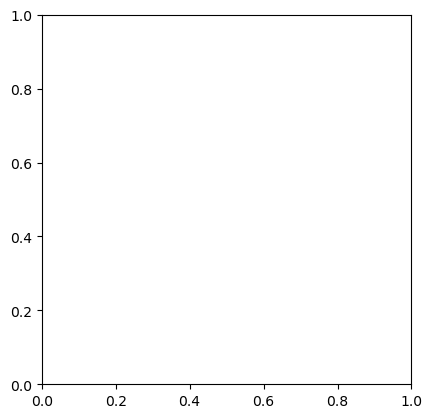

In [33]:
import matplotlib.pyplot as plt

visited_states = np.nan_to_num(visited_states)  # Converts NaNs to 0 and Infs to a large finite number

plt.imshow(observation, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Heatmap of Visited States')
plt.show()
